<ipython-input-2-95d90b9d331d>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ema = pd.Series(index=close.index)


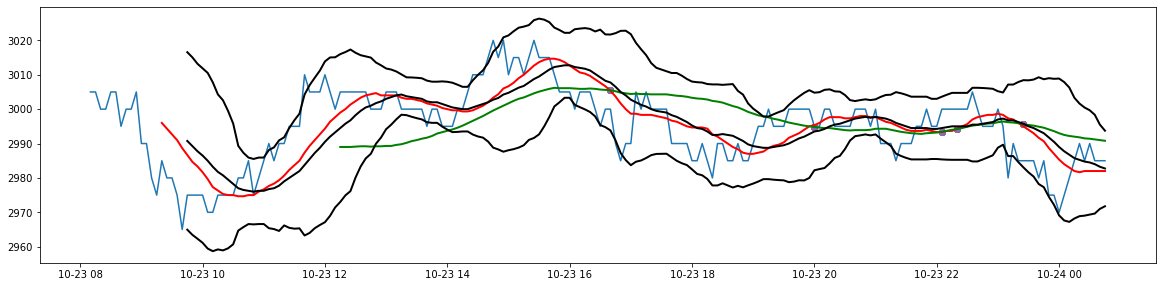

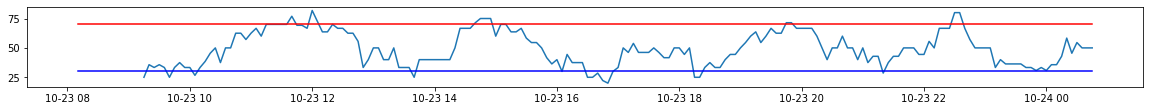

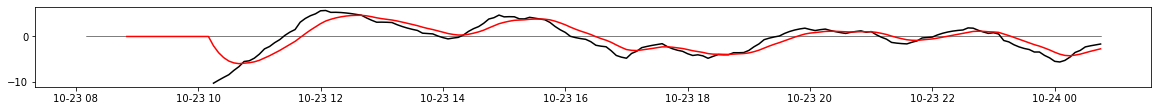

95608.87304133
None
intersection : 0
inclination_red  : 0.0
inclination_green  : -0.6999999999998181
inclination_green1  : 0.3000000000001819
bid_price    : 2985.0
ask_price    : 2990.0


In [2]:
#시뮬레이션
import pyupbit
import numpy as np
import timeit
import queue
from IPython.display import clear_output
from time import sleep
from random import *
import pandas as pd
from matplotlib import pyplot as plt
import mpl_finance
import datetime

def calcRSI(df, period):
    U = np.where(df['close'].diff(1) > 0, df['close'].diff(1), 0)
    D = np.where(df['close'].diff(1) < 0, df['close'].diff(1) * (-1), 0)
    AU = pd.DataFrame(U, index = df['date']).rolling(window=period).mean()
    AD = pd.DataFrame(D, index = df['date']).rolling(window=period).mean()
    RSI = AU / (AD + AU) * 100
    return RSI
def EMA(close, timeperiod):  # Exponential Moving Average : 지수이동평균
    k = 2/(1+timeperiod) # k : smoothing constant
    close = close.fillna(0)
    ema = pd.Series(index=close.index)
    ema[timeperiod-1] = close.iloc[0:timeperiod].sum() / timeperiod  
    for i in range(timeperiod,len(close)):
        
        ema[i] = close[i]*k + ema[i-1] * (1-k)
    return ema

def MACD(close, fastperiod=12, slowperiod=26, signalperiod=9):
    macd = EMA(close, fastperiod) - EMA(close, slowperiod)
    macd_signal = EMA(macd, signalperiod)
    macd_osc = macd - macd_signal
    df = pd.concat([macd, macd_signal, macd_osc],axis=1)
    df.columns = ['MACD','Signal','Oscillator']
    return df

current_money = 10000
current_stock = 0
data_log = []
first_flag = 1
stock_category = "KRW-EOS"

access = "7KF0HpMl8ROT4bV8ywK8CfJzGmMpYnWLxX5TGxL8"          # 본인 값으로 변경
secret = "u5GtPd5btNll7RTuVrWa4rrNUUggPPlu3Paetd6Z"          # 본인 값으로 변경
upbit = pyupbit.Upbit(access, secret)
data = pd.DataFrame(pyupbit.get_orderbook(tickers=stock_category))
bid_price = data.orderbook_units[0][0]['bid_price']
sell_price = bid_price + 5
flag1 = 0
flag2 = 1
flag3 = 1
while True :
    clear_output(wait = True)
    
    table_data = pd.DataFrame(pyupbit.get_ohlcv("KRW-EOS", interval="minute5")
                          ,columns=['open', 'high',
                             'low', 'close', 'volume'])

    table_data['date'] = table_data.index
    table_data= table_data.reset_index()
    table_data.drop(['index'],axis='columns',inplace=True)
    rolling_15 = table_data.rolling(window=15).mean()
    rolling_50 = table_data.rolling(window=50).mean()
    rolling_15['date'] = table_data['date']
    rolling_50['date'] = table_data['date']
    
    index_nan = 0
    for i in range(len(table_data.index)):
        if np.isnan(rolling_50['close'].iloc[i]) == False:
            index_nan = i
            break

    turnpoint, interval = False, False
    first_track = True
    idx = []
    for i in range(index_nan, len(table_data.index)):
        turnpoint = interval
        if rolling_15['close'].iloc[i] - rolling_50['close'].iloc[i] > 0:
            interval = True
        else:
            interval = False
        if first_track:
            first_track = False
            turnpoint = interval
        if interval != turnpoint:
            idx.append(i)

    x = table_data['date']
    y = table_data['close']
    fig = plt.figure(figsize=(20, 16))
    ax = fig.add_subplot(311)
    ax.plot(x, y)
    ax.plot(x, rolling_15['close'], label= '15-days SMA', linewidth=2, color='red')
    ax.plot(x, rolling_50['close'], label = '50-days SMA', linewidth=2, color='green')
    mbb = table_data['close'].rolling(window=20).mean()
    ubb = mbb + 2 * table_data['close'].rolling(window=20).std()
    lbb = mbb - 2 * table_data['close'].rolling(window=20).std()
    ax.plot(x, mbb, label= 'mbb', linewidth=2, color='black')
    ax.plot(x, ubb, label= 'ubb', linewidth=2, color='black')
    ax.plot(x, lbb, label= 'lbb', linewidth=2, color='black')
    
    

    RSI = calcRSI(table_data, 14)
    
    fig1 = plt.figure(figsize=(20, 5))
    ax1 = fig1.add_subplot(312)
    ax1.plot(x, RSI)
    ax1.plot(x,  [30 for i in range(len(x))], color='blue')
    ax1.plot(x,  [70 for i in range(len(x))], color='red')
    
    macd = MACD(table_data['close'])
    
    fig2 = plt.figure(figsize=(20, 5))
    ax2 = fig2.add_subplot(313)
    ax2.plot(x, macd['MACD'] ,color='black')
    ax2.plot(x,  [0 for i in range(len(x))],linewidth=0.5, color='black')
    ax2.plot(x,  macd['Signal'], color='red')
    
    for scatter in idx:
        ax.scatter(x[idx],rolling_50['close'].iloc[idx])
    #plt.legend(loc='best')
    plt.show()
    
    
    current_money = upbit.get_balance(ticker="KRW")
    print(current_money)
    current_stock = upbit.get_balance(ticker=stock_category)
    print(current_stock)
    #현재 교차점이 있는지 여부 판별
    table_data = pd.DataFrame(pyupbit.get_ohlcv(stock_category, interval="minute5")
                              ,columns=['open', 'high',
                                 'low', 'close', 'volume'])
    table_data['date'] = table_data.index
    table_data= table_data.reset_index()
    table_data.drop(['index'],axis='columns',inplace=True)
    rolling_15 = table_data.rolling(window=15).mean()
    rolling_50 = table_data.rolling(window=50).mean()
    
    table_data1 = pd.DataFrame(pyupbit.get_ohlcv(stock_category, interval="minute1")
                              ,columns=['open', 'high',
                                 'low', 'close', 'volume'])
    table_data1['date'] = table_data1.index
    table_data1= table_data1.reset_index()
    table_data1.drop(['index'],axis='columns',inplace=True)
    rolling1_50 = table_data1.rolling(window=50).mean()
    
    
    intersection = 0
    turnpoint, interval = False, False
    first_track = True
    for idx in range(len(table_data.index)-2, len(table_data.index)):
        turnpoint = interval
        if rolling_15['close'].iloc[idx] - rolling_50['close'].iloc[idx] > 0:
            interval = True
        else:
            interval = False
        if first_track:
            first_track = False
            turnpoint = interval
        if interval != turnpoint:
            intersection = idx
    print("intersection : {}".format(intersection))

    #빨간선 상승여부 판별
    vals = list(rolling_15['close'].iloc[-5:len(rolling_15)])
    vals.reverse()
    inclination_red = 0
    for i in range(3):
        inclination_red += vals[i]-vals[i+1]
    print("inclination_red  : {}".format(inclination_red))
    
    vals = list(rolling_50['close'].iloc[-5:len(rolling_50)])
    vals.reverse()
    inclination_green = 0
    for i in range(4):
        inclination_green += vals[i]-vals[i+1]
    print("inclination_green  : {}".format(inclination_green))
    
    vals = list(rolling1_50['close'].iloc[-5:len(rolling1_50)])
    vals.reverse()
    inclination_green1 = 0
    for i in range(4):
        inclination_green1 += vals[i]-vals[i+1]
    print("inclination_green1  : {}".format(inclination_green1))
    
    data = pd.DataFrame(pyupbit.get_orderbook(tickers=stock_category))
    bid_price = data.orderbook_units[0][0]['bid_price']
    print("bid_price    : {}".format(bid_price))
    
    data = pd.DataFrame(pyupbit.get_orderbook(tickers=stock_category))
    ask_price = data.orderbook_units[0][0]['ask_price']
    print("ask_price    : {}".format(ask_price))
    buy_price = ask_price
    '''
    if flag2 == 1 and upbit.get_balance(ticker=stock_category) == None and flag3 == 0 :
        flag3 = 1
        str_log = "매도 완료  현재 시간 %s"%(datetime.datetime.now())
        data_log.append(str_log)
    if inclination_red < -0.3 and flag1 == 0 and flag3 == 1:
        flag1 = 1
    #매수
    if upbit.get_balance(ticker=stock_category) == None and flag3 == 1 and flag1 == 1:
        if int(current_money/(buy_price*1.0005)) > 1 :
            if inclination_red > 3.5 and inclination_green > 2 and inclination_green1 > 1.8:
                num_buy_stock  = int(current_money/(buy_price*1.0005))
                sell_price = buy_price+5
                str_log = "매수1: %5.2f 주량: %5d 현재돈: %5.2f 현재 시간 %s"%(buy_price,num_buy_stock,current_money,datetime.datetime.now())
                data_log.append(str_log)
                str_log = upbit.buy_limit_order(stock_category, buy_price, num_buy_stock)
                data_log.append(str_log)
                flag3 = 0
                flag2 = 0
                flag1 = 0
            elif inclination_red > 3.5 and intersection != 0 and inclination_green > 1.5 and inclination_green1 > 1.8:
                num_buy_stock  = int(current_money/(buy_price*1.0005))
                sell_price = buy_price+5
                str_log = "매수2: %5.2f 주량: %5d 현재돈: %5.2f 현재 시간 %s"%(buy_price,num_buy_stock,current_money,datetime.datetime.now())
                data_log.append(str_log)
                str_log = upbit.buy_limit_order(stock_category, buy_price, num_buy_stock)
                data_log.append(str_log)
                flag3 = 0
                flag2 = 0
                flag1 = 0
    if upbit.get_balance(ticker=stock_category) != None and flag2 == 0:
        #매도
        str_log = "매도1: %5.2f 현재돈: %5.2f 현재 시간 %s"%(sell_price,current_money,datetime.datetime.now())
        data_log.append(str_log)
        str_log = upbit.sell_limit_order(stock_category, sell_price, current_stock)
        data_log.append(str_log)
        flag2 = 1
        continue

    print("current_money  : {}".format(current_money))
    print("current_stock  : {}".format(current_stock))
    for data in data_log:
        print(data)
    if current_money <0 :
        print('error')
    '''
    #sleep(1)
    break